In [1]:
from __future__ import print_function

import os
import numpy as np 
import time
import tensorflow as tf

def V_GRU(units,n_table):
    #weight_initializer = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.05)
    #weight_initializer = tf.keras.initializers.GlorotUniform()
    #weight_initializer = tf.keras.initializers.GlorotNormal()
    #weight_initializer = tf.keras.initializers.HeNormal()
    weight_initializer = tf.keras.initializers.HeUniform()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.GRU(units=units,
                                input_shape=(None, n_table),
                                return_sequences=True,
                                kernel_initializer=weight_initializer,recurrent_dropout = 0.2,
                                dropout=0.2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.GRU(units=units,
                                input_shape=(None, n_table),
                                return_sequences=True,
                                kernel_initializer=weight_initializer,recurrent_dropout = 0.2,
                                dropout=0.3))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.GRU(units=units,
                                input_shape=(None, n_table),
                                return_sequences=True,
                                kernel_initializer=weight_initializer,recurrent_dropout = 0.2,
                                dropout=0.3))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.GRU(units=units,
                                input_shape=(None, n_table),
                                return_sequences=True,
                                kernel_initializer=weight_initializer,recurrent_dropout = 0.2,
                                dropout=0.3))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.GRU(units=units,
                                input_shape=(None, n_table),
                                return_sequences=True,
                                kernel_initializer=weight_initializer,recurrent_dropout = 0.2,
                                dropout=0.4))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.GRU(units=units,
                                input_shape=(None, n_table),
                                return_sequences=True,
                                kernel_initializer=weight_initializer,recurrent_dropout = 0.2,
                                dropout=0.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(units=512,activation='relu',kernel_initializer=weight_initializer))
    model.add(tf.keras.layers.Dense(units=n_table,activation='softmax',kernel_initializer=weight_initializer))
    return model

In [2]:
def generate(model,sequence,tokenizer,MAX_LEN=128):
    while (sequence[-1] != 'E') and (len(tokenizer.tokenize(sequence)) <= MAX_LEN):
        x = tokenizer.one_hot_encode(tokenizer.tokenize(sequence))
        preds = model.predict_on_batch(x)[0][-1]
        next_idx = top_k_sampling(preds)
        sequence += tokenizer.table[next_idx]
        
    sequence = sequence[1:].rstrip('E')
    return sequence

def sample_with_temp(preds,sampling_temp=0.75):
    streched = np.log(preds) / sampling_temp
    streched_probs = np.exp(streched) / np.sum(np.exp(streched))
    return np.random.choice(range(len(streched)), p=streched_probs)

def top_k_sampling(preds, k=5):
    top_k_probabilities, top_k_indices= tf.math.top_k(preds, k=k, sorted=True)
    top_k_indices = np.asarray(top_k_indices).astype("int32")
    top_k_redistributed_probability=softmax(np.log(top_k_probabilities))
    top_k_redistributed_probability = np.asarray(top_k_redistributed_probability).astype("float32")
    sampled_token = np.random.choice(top_k_indices, p=top_k_redistributed_probability)
    return sampled_token
    
def greedy_search(preds):
    return (np.argmax(preds))   

In [3]:
class SmilesTokenizer(object):
    def __init__(self):
        atoms = ['Al', 'As', 'B', 'Br', 'C', 'Cl', 
                 'F', 'H', 'I', 'K', 'Li', 'N',
                 'Na', 'O', 'P', 'S', 'Se', 'Si', 'Te']
        special = ['(', ')', '[', ']', '=', '#', '%', '0', '1', '2', '3', '4', '5',
            '6', '7', '8', '9', '+', '-', 'se', 'te', 'c', 'n', 'o', 's']
        padding = ['G', 'A', 'E']

        self.table = sorted(atoms, key=len, reverse=True) + special + padding
        table_len = len(self.table)

        self.table_2_chars = list(filter(lambda x: len(x) == 2, self.table))
        self.table_1_chars = list(filter(lambda x: len(x) == 1, self.table))

        self.one_hot_dict = {}
        for i, symbol in enumerate(self.table):
            vec = np.zeros(table_len, dtype=np.float32)
            vec[i] = 1
            self.one_hot_dict[symbol] = vec

    def tokenize(self, smiles):
        smiles = smiles + ' '
        N = len(smiles)
        token = []
        i = 0
        while (i < N):
            c1 = smiles[i]
            c2 = smiles[i:i + 2]

            if c2 in self.table_2_chars:
                token.append(c2)
                i += 2
                continue

            if c1 in self.table_1_chars:
                token.append(c1)
                i += 1
                continue

            i += 1

        return token

    def one_hot_encode(self, tokenized_smiles):
        result = np.array(
            [self.one_hot_dict[symbol] for symbol in tokenized_smiles],
            dtype=np.float32)
        result = result.reshape(1, result.shape[0], result.shape[1])
        return result


In [4]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _int64_feature(value):
      return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _float_feature(value):
      return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def to_tfrecord(data,save_dir,r_num,tokenizer):
    tfrecord_name='{}.tfrecord'.format(r_num)
    tfrecord_path=os.path.join(save_dir,tfrecord_name)
    with tf.io.TFRecordWriter(tfrecord_path) as writer:    
        for tp_smi in data:
            X = np.array([tokenizer.one_hot_dict[symbol] for symbol in tp_smi[:-1]],dtype=np.uint8)
            y = np.array([tokenizer.one_hot_dict[symbol] for symbol in tp_smi[1:]],dtype=np.uint8)
            _,X_coded = cv2.imencode('.png',X)
            _,y_coded = cv2.imencode('.png',y)
            x_bytes = X_coded.tobytes()
            y_bytes = y_coded.tobytes()
            data_dict ={  'X':_bytes_feature(x_bytes),
                          'Y':_bytes_feature(y_bytes)}
            features=tf.train.Features(feature=data_dict)
            example= tf.train.Example(features=features)
            serialized=example.SerializeToString()
            writer.write(serialized)   

def create_records(_smiles,save_path,mode,tokenizer,BATCH_SIZE=10240):
    print('Saving The data to tfrecord:',mode)
    for i in  tqdm(range(0,len(_smiles),BATCH_SIZE)):
        data=_smiles[i:BATCH_SIZE+i]
        r_num=i//BATCH_SIZE
        to_tfrecord(data,save_path,r_num,tokenizer)

def data_input_fn(data_path,mode,DATA_DIM,BATCH_SIZE,BUFFER_SIZE): 
    def _parser(example):
        feature ={  'X'  : tf.io.FixedLenFeature([],tf.string) ,
                    'Y'  : tf.io.FixedLenFeature([],tf.string)}    
        parsed_example=tf.io.parse_single_example(example,feature)
        inp=parsed_example['X']
        inp=tf.image.decode_png(inp,channels=1)
        inp=tf.cast(inp,tf.float32)
        inp=tf.reshape(inp,DATA_DIM)
        
        tgt=parsed_example['Y']
        tgt=tf.image.decode_png(tgt,channels=1)
        tgt=tf.cast(tgt,tf.float32)
        tgt=tf.reshape(tgt,DATA_DIM)
        
        return inp,tgt
    _pattern=os.path.join(data_path,mode,'*.tfrecord')
    file_paths = tf.io.gfile.glob(_pattern)
    dataset = tf.data.TFRecordDataset(file_paths)
    dataset = dataset.map(_parser)
    dataset = dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

def check_smi(smi):
    m = Chem.MolFromSmiles(smi,sanitize=False)
    if m is None:
        print('invalid SMILE:',smi)
        return None
    else:
        try:
            Chem.SanitizeMol(m)
            return smi
        except:
            print('invalid chemistry:',smi)
            return None

In [5]:
DATA_SMI     = '/data/250k_rndm_zinc_drugs_clean_3.csv' 
TFRECORD_PATH= '/data/tfrecSMDsample'  
EVAL_SPLIT   = 0.2

In [6]:
def create_dir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

In [7]:
import os
import numpy as np
from rdkit import Chem
from tqdm.notebook import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import pandas as pd
tokenizer=SmilesTokenizer()

TRAIN_DIR= os.path.join(TFRECORD_PATH,'Train')
EVAL_DIR = os.path.join(TFRECORD_PATH,'Eval')

create_dir(TFRECORD_PATH)
create_dir(TRAIN_DIR)
create_dir(EVAL_DIR)

TRAIN_DIR= '/data/tfrecSMDsample/Train'
EVAL_DIR = '/data/tfrecSMDsample/Eval'

249455
C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1



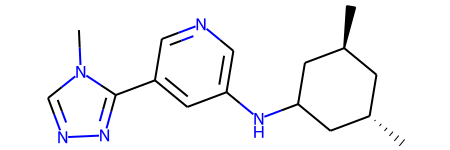

In [8]:
import pandas as pd
smiles = pd.read_csv(DATA_SMI)
smiles = smiles['smiles'].values
print(len(smiles))    
print(smiles[1])   
molecule=Chem.MolFromSmiles(smiles[1])
molecule

In [9]:
data = pd.read_csv(DATA_SMI)
data.describe()

logP            qed            SAS
count  249455.000000  249455.000000  249455.000000
mean        2.457093       0.728264       3.053235
std         1.434330       0.139565       0.834796
min        -6.876200       0.111811       1.132738
25%         1.574810       0.645872       2.416627
50%         2.605600       0.759878       2.892993
75%         3.486760       0.835714       3.545533
max         8.252100       0.947882       7.289283

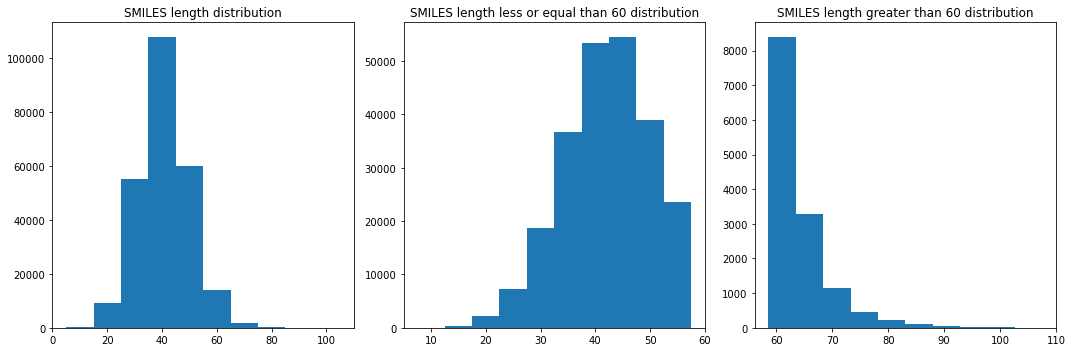

In [10]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
axes[0].set_title("SMILES length distribution")
axes[0].hist(data['smiles'].str.len(), align = 'left')
axes[1].set_title("SMILES length less or equal than 60 distribution")
axes[1].hist(data[data['smiles'].str.len() <= 60]['smiles'].str.len(), align = 'left')
axes[2].set_title("SMILES length greater than 60 distribution")
axes[2].hist(data[data['smiles'].str.len() > 60]['smiles'].str.len(), align = 'left')
fig.tight_layout()

In [11]:
import os
import os
import numpy as np
from rdkit import Chem
from tqdm.notebook import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
tokenizer=SmilesTokenizer()

In [12]:
tokenized_smiles = [tokenizer.tokenize(smi) for smi in tqdm(smiles)]

SMI_MAX_LEN=0
for smi in tqdm(tokenized_smiles):
    _smi_len=len(smi)
    if _smi_len > SMI_MAX_LEN:
        SMI_MAX_LEN=_smi_len

padded_smiles = [['G'] + tokenized_smi + ['E']+
                 ['A' for _ in range(SMI_MAX_LEN -len(tokenized_smi))]
                 for tokenized_smi in tqdm(tokenized_smiles)]

eval_data_len=int(len(padded_smiles)*EVAL_SPLIT)
train_smiles= padded_smiles[eval_data_len:]
eval_smiles = padded_smiles[:eval_data_len]

create_records(train_smiles,TRAIN_DIR,'Train',tokenizer)
create_records(eval_smiles,EVAL_DIR,'Eval',tokenizer)

  0%|          | 0/249455 [00:00<?, ?it/s]

  0%|          | 0/249455 [00:00<?, ?it/s]

  0%|          | 0/249455 [00:00<?, ?it/s]

Saving The data to tfrecord: Train


  0%|          | 0/20 [00:00<?, ?it/s]

Saving The data to tfrecord: Eval


  0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
import sys
example_smile=smiles[0]
tokenized=tokenizer.tokenize(example_smile)
padded=['G'] + tokenized + ['E']+ ['A' for _ in range(SMI_MAX_LEN -len(tokenized))]
X = np.array([tokenizer.one_hot_dict[symbol] for symbol in padded[:-1]])
y = np.array([tokenizer.one_hot_dict[symbol] for symbol in padded[1:]])

In [14]:
X=X.astype(np.uint8)
y=y.astype(np.uint8)

In [15]:
_,X_coded = cv2.imencode('.png',X)
_,y_coded = cv2.imencode('.png',y)
x_bytes = X_coded.tobytes()
y_bytes = y_coded.tobytes()

In [16]:
BATCH_SIZE=64
BUFFER_SIZE=256
DATA_DIM=(SMI_MAX_LEN+1,len(tokenizer.table))

example_ds = data_input_fn(TFRECORD_PATH,'Train',DATA_DIM,BATCH_SIZE,BUFFER_SIZE)
for x,y in example_ds.take(1):
  print(x.shape,y.shape,x[0],y[0])

(64, 96, 47) (64, 96, 47) tf.Tensor(
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]], shape=(96, 47), dtype=float32) tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]], shape=(96, 47), dtype=float32)


In [19]:
from glob import glob 
import os 
import tensorflow as tf
model_name='lstm_chem' 
iden=str(model_name).upper()
BUCKET='tfalldata' 
TFIDEN='tfrecSMDsample' 
SMI_MAXLEN=95 
TOKENIZER_TABLE_LEN=47 
DATA_DIM=(SMI_MAXLEN+1,TOKENIZER_TABLE_LEN)
BATCH_SIZE=512 
BUFFER_SIZE=256 
TRAIN_DATA=199000*1 
EVAL_DATA=49800

EPOCHS=10
 
TOTAL_DATA=TRAIN_DATA+EVAL_DATA
STEPS_PER_EPOCH = TOTAL_DATA//BATCH_SIZE
EVAL_STEPS      = EVAL_DATA//BATCH_SIZE
GCS_PATH='/data/tfrecSMDsample'.format(BUCKET,TFIDEN)
print(GCS_PATH)

WEIGHT_PATH=os.path.join(os.getcwd(),'weights','{}.h5'.format(iden))
if os.path.exists(WEIGHT_PATH):
  LOAD_WEIGHTS=True 
else:
  LOAD_WEIGHTS=False

C:/Users/dimav/Desktop/pet_proj/Drug Generator/data/tfrecSMDsample


In [20]:
eval_ds = data_input_fn(GCS_PATH,'Train',DATA_DIM,BATCH_SIZE,BUFFER_SIZE)
train_ds =data_input_fn(GCS_PATH,'Eval',DATA_DIM,BATCH_SIZE,BUFFER_SIZE)
for x,y in eval_ds.take(1):
  print(x.shape)
  print(y.shape)

(512, 96, 47)
(512, 96, 47)


In [21]:
model = V_GRU(256,TOKENIZER_TABLE_LEN)
model.compile(optimizer="Adam",
                loss="categorical_crossentropy",
                metrics=["accuracy"])
if LOAD_WEIGHTS:
    model.load_weights(WEIGHT_PATH)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 256)         234240    
                                                                 
 batch_normalization (BatchN  (None, None, 256)        1024      
 ormalization)                                                   
                                                                 
 gru_1 (GRU)                 (None, None, 256)         394752    
                                                                 
 batch_normalization_1 (Batc  (None, None, 256)        1024      
 hNormalization)                                                 
                                                                 
 gru_2 (GRU)                 (None, None, 256)         394752    
                                                                 
 batch_normalization_2 (Batc  (None, None, 256)        1

In [23]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime, os
%matplotlib inline
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                  cooldown= 10,
                                                  patience=10,
                                                  verbose =1,
                                                  min_lr=1e-5)

mode_autosave = tf.keras.callbacks.ModelCheckpoint(WEIGHT_PATH,
                                                  save_best_only=True, 
                                                  verbose=1, 
                                                  period =10)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=15,verbose=1, mode = 'auto') 
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [mode_autosave, lr_reducer,early_stopping]



history = model.fit(train_ds,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=10,
                    verbose=1,
                    validation_data=eval_ds,
                    validation_steps=EVAL_STEPS,
                    callbacks=callbacks)

Final_weights=os.path.join(os.getcwd(),'lstm_chem_final.h5')
model.save_weights(Final_weights)

Epoch 1/10
485/485 [==============================] - 489s 990ms/step - loss: 0.6976 - accuracy: 0.7821 - val_loss: 0.4392 - val_accuracy: 0.8521
Epoch 2/10
485/485 [==============================] - 480s 990ms/step - loss: 0.4092 - accuracy: 0.8620 - val_loss: 0.3501 - val_accuracy: 0.8791
Epoch 3/10
485/485 [==============================] - 475s 980ms/step - loss: 0.3553 - accuracy: 0.8772 - val_loss: 0.3235 - val_accuracy: 0.8866
Epoch 4/10
485/485 [==============================] - 473s 975ms/step - loss: 0.3313 - accuracy: 0.8840 - val_loss: 0.3079 - val_accuracy: 0.8912
Epoch 5/10
485/485 [==============================] - 476s 982ms/step - loss: 0.3173 - accuracy: 0.8881 - val_loss: 0.2982 - val_accuracy: 0.8942
Epoch 6/10
485/485 [==============================] - 477s 984ms/step - loss: 0.3077 - accuracy: 0.8909 - val_loss: 0.2912 - val_accuracy: 0.8964
Epoch 7/10
485/485 [==============================] - 474s 977ms/step - loss: 0.3004 - accuracy: 0.8932 - val_loss: 0.2881 -

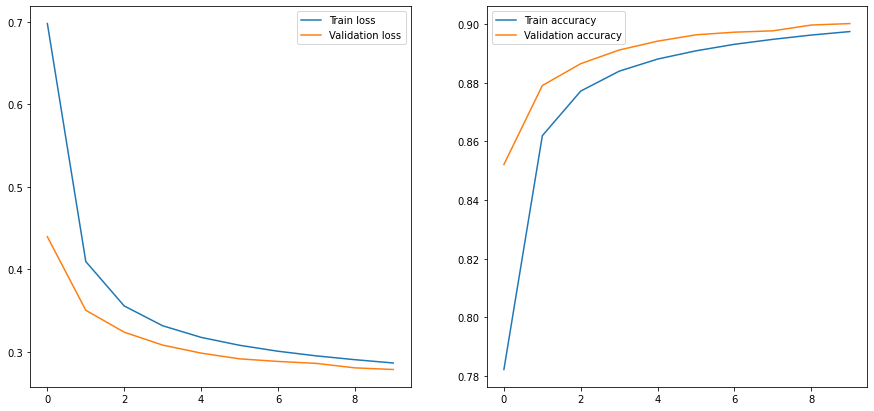

In [24]:
def plot_history(history):
  fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,7))
  ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
  ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
  ax_loss.legend()
  ax_acc.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
  ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
  ax_acc.legend()
  plt.show()
plot_history(history)

In [25]:
import pandas as pd
DATA_SMI     = '/data/250k_rndm_zinc_drugs_clean_3.csv'
smiles = pd.read_csv(DATA_SMI)
smiles = smiles['smiles'].values
NB_MOL=100

In [26]:
import os
from rdkit import Chem
tokenizer=SmilesTokenizer()
from tqdm.notebook import tqdm

TOKENIZER_TABLE_LEN=len(tokenizer.table)
WEIGHT_PATH='./lstm_chem_final.h5'
model = V_GRU(256,TOKENIZER_TABLE_LEN)
model.load_weights(WEIGHT_PATH)
print('Loaded Model Weights') 

Loaded Model Weights


In [27]:
from scipy.special import softmax
new_smiles=[]
NB_MOL = 100
print('Generating New Molecules')
for _ in tqdm(range(NB_MOL)):
    smile='G'
    smi=generate(model,smile,tokenizer)
    smi=check_smi(smi)
    if smi is not None and smi not in train_smiles:
        new_smiles.append(smi)

Generating New Molecules


  0%|          | 0/100 [00:00<?, ?it/s]

invalid chemistry: O=C(Cc1cn2ccnc2n1)Nc1ccc(Cl)cc1N1CCCC1
invalid SMILE: COc1ccc(C(=O)N(C[CH]2CCC(=O)NC2(C)C)[nH+]c1
invalid SMILE: COc1ccc(C[NH+]2CCC([CH]3NN=C(c4ccco3)C3=O)[CH]2c2ccccc2)cc1


2022-05-04 20:45:12.344194: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-05-04 20:45:15.076434: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


invalid SMILE: C[C]12CC3=C4C=CC[CH]([CH](O)[NH+]3CCC[C]13C3)C(=O)N2Cc1cccc(Br)c1
invalid SMILE: N#C[CH]1CCC[CH](NC(=O)NCc2cc3c(s2)CC(Cl)(C(=O)Nc2ccc(Cl)cc2)C1
invalid SMILE: Cc1ccc(C)c(OCC[NH+]2CCCN(CC[CH]3CCC[NH+](C)C2)c1
invalid chemistry: CC[CH]1CCCN(C(=O)c2cn(Cc3ccc(Cl)c(Cl)c3)nn2C)[nH]c1=O
invalid chemistry: C[CH](CC[NH2+]Cc1cn2ccnn2n1)c1cc(Cl)ccc1F
invalid chemistry: O=C(NC[CH](c1ccc(Cl)cc1)N1CCN(c2ccccc2)CC1)c1nc([O-])c(=O)n(-c2ccccc2)c1=O


2022-05-04 20:46:16.828165: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-05-04 20:46:16.842638: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-05-04 20:46:16.857860: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-05-04 20:46:43.423551: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-05-04 20:46:43.454698: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


invalid SMILE: COc1ccc(NC(=O)C[CH](NC(=O)c2ccc3c(c2)CCCN3S(C)(=O)=O)cc1
invalid SMILE: COc1ccc(C(=O)N2CCC[CH]2c(C(=O)[O-])cc1
invalid chemistry: O=C(CCC1=NN(c2ccccc2)=NO1)N1CCC[CH](C(=O)c2ccc(OC(F)(F)F)cc2)C1
invalid chemistry: O=C(Nc1cccc(NC(=O)c2ccc(F)cn2)c1)Nc1cccc2cccnn12


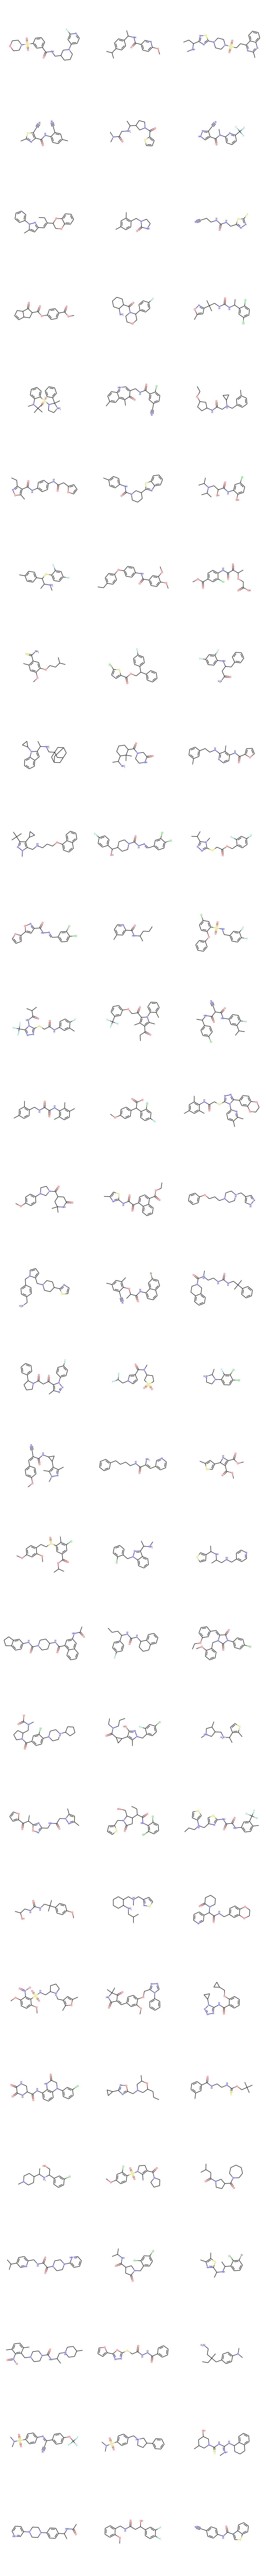

In [28]:
generated = [Chem.MolFromSmiles(x) for x in new_smiles]
Chem.Draw.MolsToGridImage(generated, molsPerRow=3, maxMols=NB_MOL, subImgSize=(400, 400))

In [29]:
print(sorted([x.GetNumAtoms() for x in generated]))

[15, 15, 15, 15, 17, 17, 18, 18, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 30, 31, 31, 31, 31, 32, 32, 32, 32, 33, 35, 37]


In [30]:
good_mol_list = [x for x in generated if x.GetNumAtoms() > 10 and x.GetNumAtoms() < 50]
print(len(good_mol_list))

87


In [31]:
from rdkit.Chem import QED
qed_list = [QED.qed(x) for x in good_mol_list]
final_mol_list = [(a,b) for a,b in zip(good_mol_list,qed_list) if b > 0.2]

In [32]:
print(len(final_mol_list))

87


/opt/conda/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:254: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


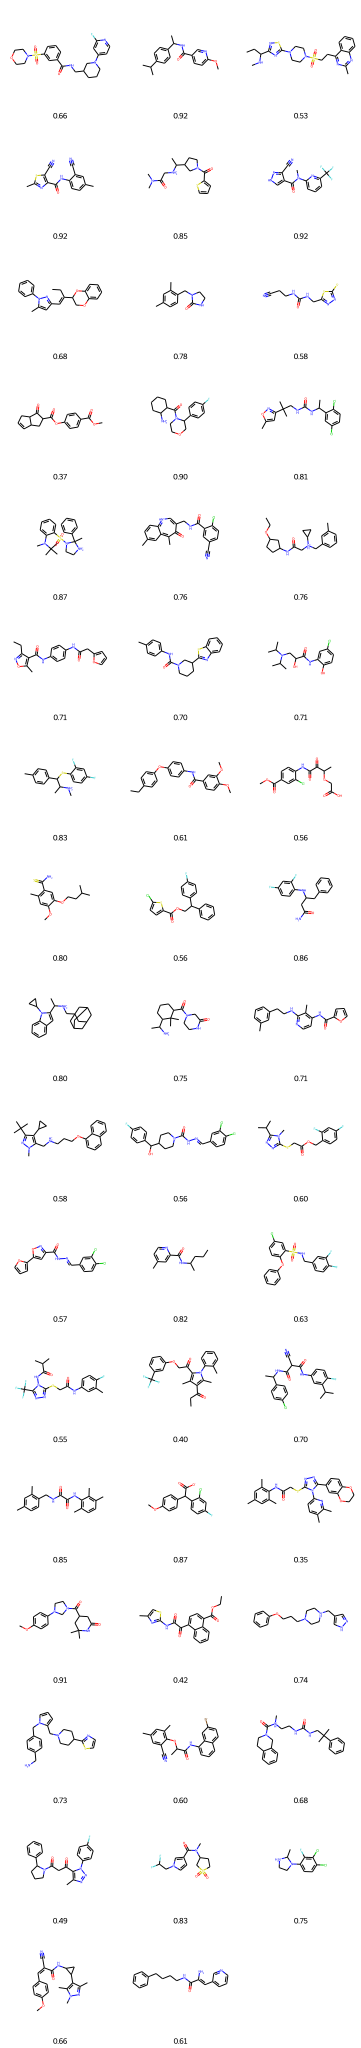

In [33]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([x[0] for x in final_mol_list],
               molsPerRow=3,useSVG=True,
               subImgSize=(250, 250),
               legends=[f"{x[1]:.2f}" for x in final_mol_list])

In [34]:
from rdkit.Chem import AllChem, Draw
from rdkit import rdBase, Chem, DataStructs

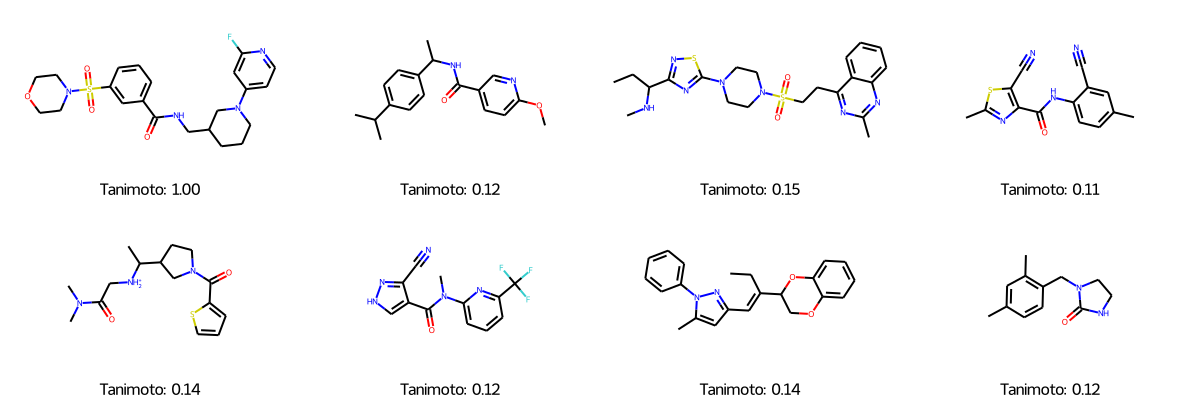

In [35]:
from rdkit.Chem import AllChem, Draw
from rdkit import rdBase, Chem, DataStructs

morgan_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048) for mol in generated]
tanimoto = DataStructs.BulkTanimotoSimilarity(morgan_fp[0], morgan_fp)
Draw.MolsToGridImage(generated[:8], molsPerRow=4, subImgSize=(300,200), legends=['Tanimoto: {:.2f}'.format(i) for i in tanimoto])


In [ ]:
from rdkit.Chem.Fraggle import FraggleSim


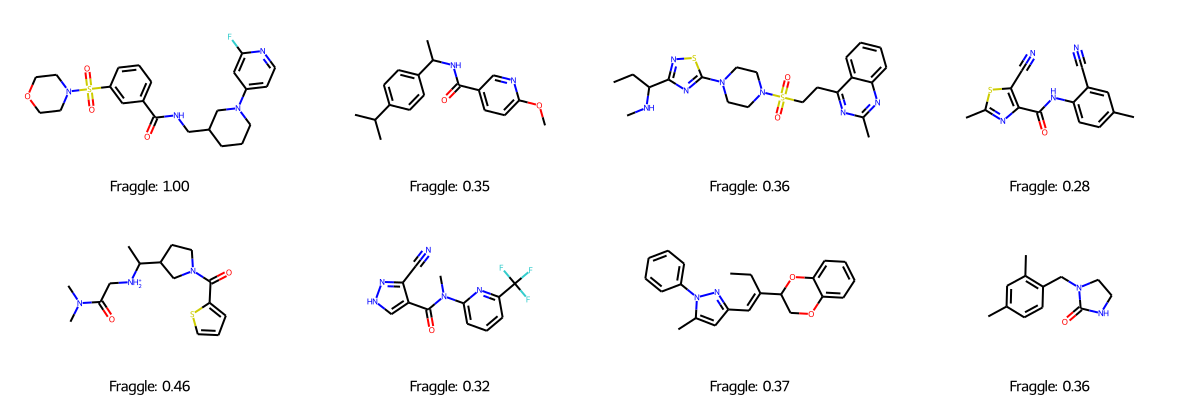

In [36]:
from rdkit.Chem.Fraggle import FraggleSim
 
fraggle_similarity = []
for (sim, match) in [FraggleSim.GetFraggleSimilarity(generated[0], generated[i]) for i in range(len(generated))]:
    fraggle_similarity.append(sim)
Draw.MolsToGridImage(generated[:8], molsPerRow=4, subImgSize=(300,200), legends=['Fraggle: {:.2f}'.format(i) for i in fraggle_similarity])

In [40]:
from rdkit.Chem import Descriptors 
import rdkit
tspa = Descriptors.TPSA(generated[0])
MolLogP = Descriptors.MolLogP(generated[0])
qed = QED.qed(generated[0])
nhbacceptors = rdkit.Chem.rdMolDescriptors.CalcNumHBA((generated[0]))
nbdonors = rdkit.Chem.rdMolDescriptors.CalcNumHBD((generated[0]))

In [43]:
tspa = []
for i in range(len(generated)):
    tspa.append(Descriptors.TPSA(generated[i]))

In [44]:
MolLogP = []
for i in range(len(generated)):
    MolLogP.append(Descriptors.MolLogP(generated[i]))

In [45]:
ExactMolWt = []
for i in range(len(generated)):
    ExactMolWt.append(Descriptors.ExactMolWt(generated[i]))

In [46]:
HeavyAtomMolWt = []
for i in range(len(generated)):
    HeavyAtomMolWt.append(Descriptors.HeavyAtomMolWt(generated[i]))

In [47]:
MolWt = []
for i in range(len(generated)):
    MolWt.append(Descriptors.MolWt(generated[i]))

In [48]:
qed = []
for i in range(len(generated)):
    qed.append(QED.qed(generated[i]))

In [49]:
numatoms = []
for i in range(len(generated)):
    numatoms.append(generated[i].GetNumAtoms())

In [50]:
smiles_list = []
for i in range(len(generated)):
    smiles_list.append(Chem.MolToSmiles(generated[i]))

In [51]:
nhbacceptors = []
for i in range(len(generated)):
    nhbacceptors.append(rdkit.Chem.rdMolDescriptors.CalcNumHBA((generated[i])))

In [52]:
nbdonors = []
for i in range(len(generated)):
    nbdonors.append(rdkit.Chem.rdMolDescriptors.CalcNumHBD((generated[i])))

In [53]:
df_first_etap_top_k_sampling = pd.DataFrame(list(zip(tspa, MolLogP, qed,ExactMolWt,MolWt,HeavyAtomMolWt,smiles_list,numatoms,nhbacceptors,nbdonors)), columns = ['tspa', 'logp', 'qed','ExactMolWt','MolWt','HeavyAtomMolWt','smiles_list','num_atoms','h-acceptors','h-donors'])

In [54]:
df_first_etap_top_k_sampling

tspa     logp       qed  ExactMolWt    MolWt  HeavyAtomMolWt  \
0    91.84  1.88800  0.659547  462.173705  462.547         435.331   
1    51.22  3.70460  0.915277  298.168128  298.386         276.210   
2   104.21  2.15472  0.528537  475.182415  475.644         446.412   
3    89.57  2.75560  0.916598  282.057532  282.328         272.248   
4    57.23  0.25030  0.847486  310.158374  310.443         286.251   
..     ...      ...       ...         ...      ...             ...   
82   41.82  1.50930  0.892507  345.163125  345.488         320.288   
83   61.50  0.29720  0.329241  361.205659  361.535         332.303   
84   49.72  2.02440  0.935587  325.202288  325.436         300.236   
85   58.56  2.71330  0.859932  321.117650  321.323         304.187   
86   52.89  4.02528  0.769198  278.051384  278.336         268.256   

                                          smiles_list  num_atoms  h-acceptors  \
0   O=C(NCC1CCCN(c2ccnc(F)c2)C1)c1cccc(S(=O)(=O)N2...         32            6   
1               COc1ccc(C(=O)NC(C)c2ccc(C(C)C)cc2)cn1         22            3   
2   CCC(NC)c1nsc(N2CCN(S(=O)(=O)CCc3nc(C)nc4ccccc3...         32            9   
3                 Cc1ccc(NC(=O)c2nc(C)sc2C#N)c(C#N)c1         20            5   
4          CC([NH2+]CC(=O)N(C)C)C1CCN(C(=O)c2cccs2)C1         21            3   
..                                                ...        ...          ...   
82     CN(C)S(=O)(=O)c1ccc(C[NH+]2CCC(c3ccccc3)C2)cc1         24            2   
83      C[NH+]=C(NC(=S)N1CC(C)CC(O)C1)NC1CCCc2ccccc21         25            2   
84        CC(=O)NC(C)c1ccc(N2CCN(c3ccc[nH+]c3)CC2)cc1         24            3   
85               COc1ccccc1CNC(=O)CC(O)c1ccc(F)c(F)c1         23            3   
86                   N#Cc1ccc(NC(=O)c2csc3ccccc23)cc1         20            3   

    h-donors  
0          1  
1          1  
2          1  
3          1  
4          1  
..       ...  
82         1  
83         4  
84         1  
85         2  
86         1  

[87 rows x 10 columns]

In [55]:
df_first_etap_top_k_sampling.describe()

tspa       logp        qed  ExactMolWt       MolWt  \
count   87.000000  87.000000  87.000000   87.000000   87.000000   
mean    63.570115   2.852529   0.701406  348.613123  349.054276   
std     24.060482   1.509786   0.155430   66.457051   66.568475   
min     16.610000   0.017700   0.329241  204.126263  204.273000   
25%     46.945000   1.803690   0.580875  298.653176  298.860000   
50%     61.500000   2.639400   0.735514  345.163125  345.488000   
75%     80.695000   4.062600   0.816938  392.715786  393.228500   
max    125.350000   6.275760   0.935587  515.199111  515.639000   

       HeavyAtomMolWt  num_atoms  h-acceptors   h-donors  
count       87.000000  87.000000    87.000000  87.000000  
mean       327.283793  24.344828     3.735632   1.310345  
std         64.627168   4.744219     1.755124   0.893261  
min        188.145000  15.000000     1.000000   0.000000  
25%        281.929500  21.000000     3.000000   1.000000  
50%        324.254000  24.000000     3.000000   1.000000  
75%        369.978000  27.500000     5.000000   2.000000  
max        486.407000  37.000000     9.000000   4.000000

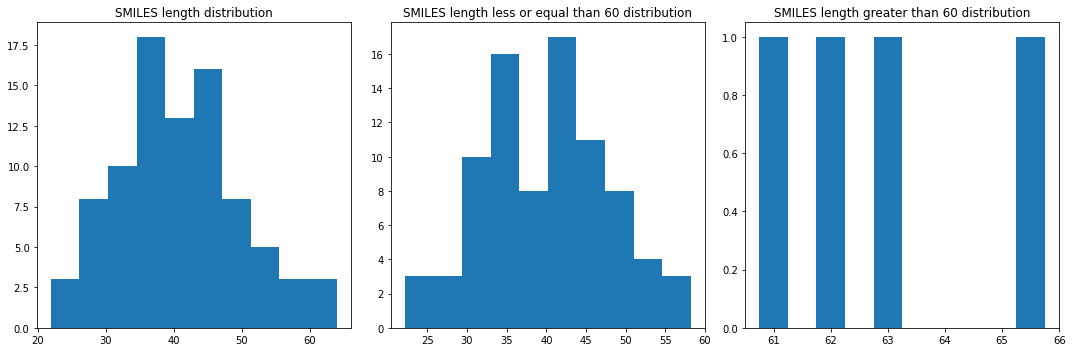

In [56]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
axes[0].set_title("SMILES length distribution")
axes[0].hist(df_first_etap_top_k_sampling['smiles_list'].str.len(), align = 'left')
axes[1].set_title("SMILES length less or equal than 60 distribution")
axes[1].hist(df_first_etap_top_k_sampling[df_first_etap_top_k_sampling['smiles_list'].str.len() <= 60]['smiles_list'].str.len(), align = 'left')
axes[2].set_title("SMILES length greater than 60 distribution")
axes[2].hist(df_first_etap_top_k_sampling[df_first_etap_top_k_sampling['smiles_list'].str.len() > 60]['smiles_list'].str.len(), align = 'left')
fig.tight_layout()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='qed', ylabel='Density'>

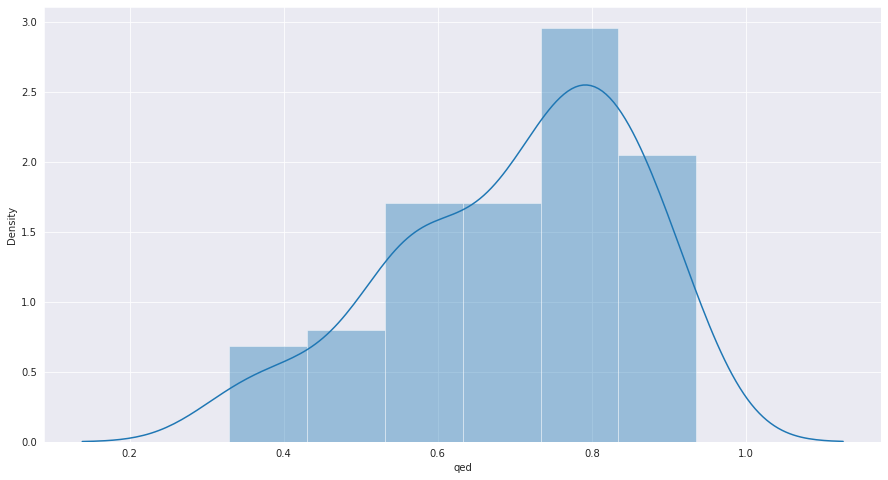

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap_top_k_sampling['qed'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='h-acceptors', ylabel='Density'>

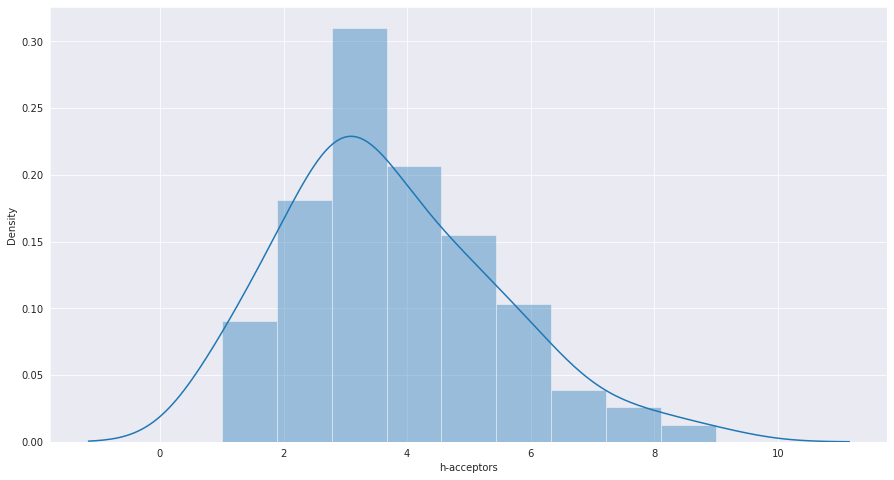

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap_top_k_sampling['h-acceptors'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='h-donors', ylabel='Density'>

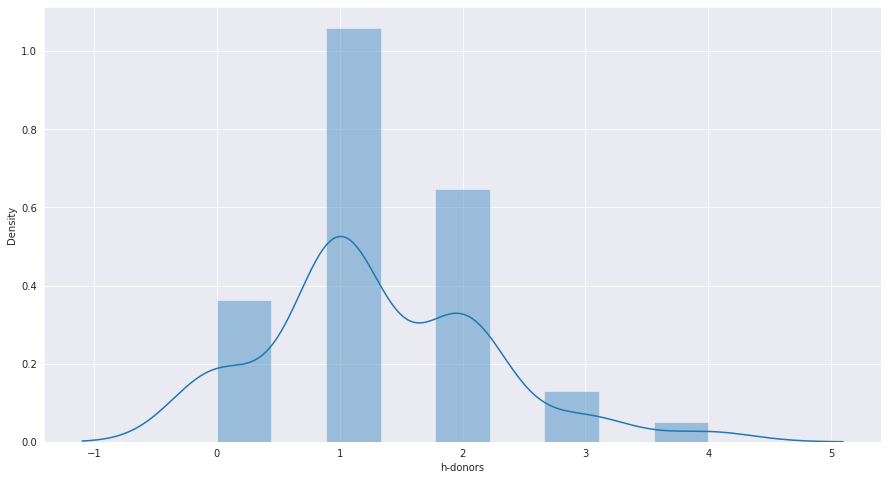

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap_top_k_sampling['h-donors'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ExactMolWt', ylabel='Density'>

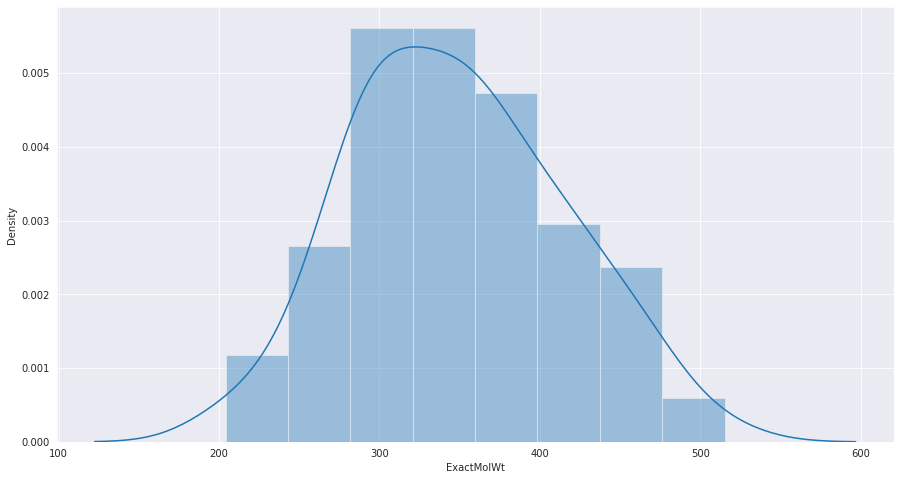

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap_top_k_sampling['ExactMolWt'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='logp', ylabel='Density'>

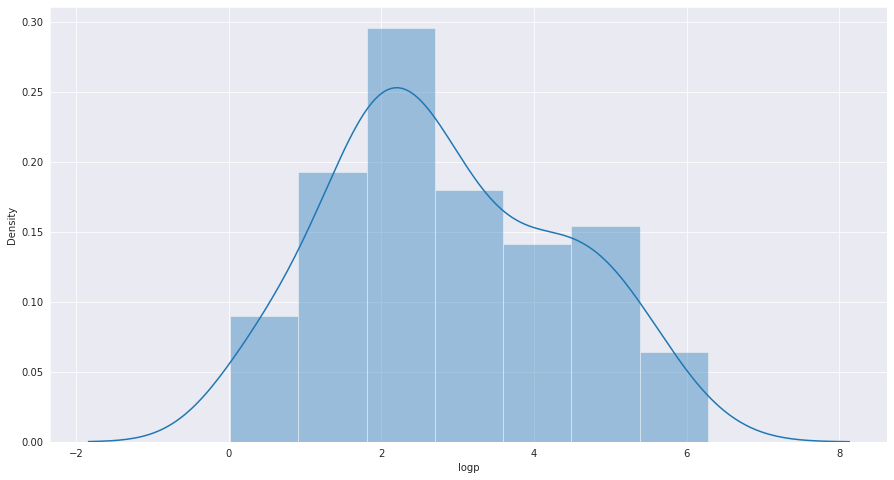

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap_top_k_sampling['logp'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='num_atoms', ylabel='Density'>

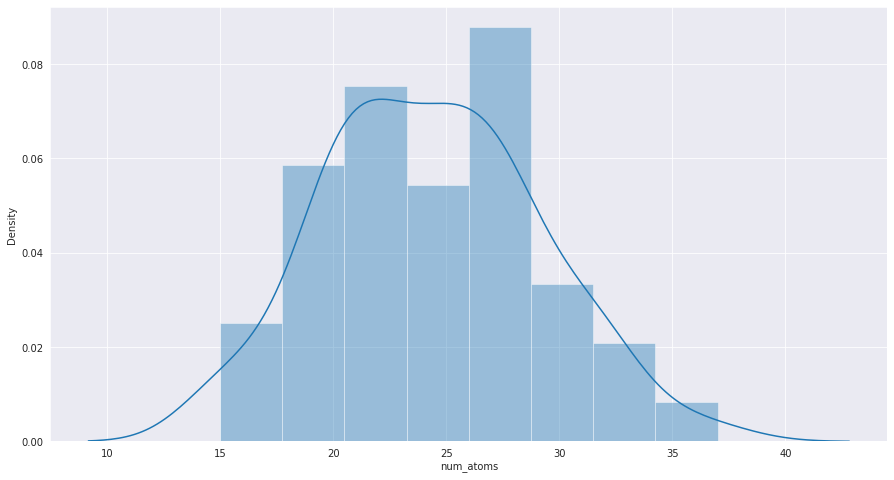

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap_top_k_sampling['num_atoms'])

In [63]:
def generate(model,sequence,tokenizer,MAX_LEN=128):
    while (sequence[-1] != 'E') and (len(tokenizer.tokenize(sequence)) <= MAX_LEN):
        x = tokenizer.one_hot_encode(tokenizer.tokenize(sequence))
        preds = model.predict_on_batch(x)[0][-1]
        next_idx = sample_with_temp(preds)
        sequence += tokenizer.table[next_idx]
        
    sequence = sequence[1:].rstrip('E')
    return sequence

def sample_with_temp(preds,sampling_temp=0.75):
    streched = np.log(preds) / sampling_temp
    streched_probs = np.exp(streched) / np.sum(np.exp(streched))
    return np.random.choice(range(len(streched)), p=streched_probs)

In [65]:
import os
from rdkit import Chem
tokenizer=SmilesTokenizer()
from tqdm.notebook import tqdm

TOKENIZER_TABLE_LEN=len(tokenizer.table)
WEIGHT_PATH='./lstm_chem_final.h5'
model = V_GRU(256,TOKENIZER_TABLE_LEN)
model.load_weights(WEIGHT_PATH)
print('Loaded Model Weights') 

Loaded Model Weights


In [66]:
from scipy.special import softmax
new_smiles=[]
print('Generating New Molecules')
for _ in tqdm(range(NB_MOL)):
    smile='G'
    smi=generate(model,smile,tokenizer)
    smi=check_smi(smi)
    if smi is not None and smi not in train_smiles:
        new_smiles.append(smi)

Generating New Molecules


  0%|          | 0/100 [00:00<?, ?it/s]

invalid SMILE: Cc1ccc(C(=O)Nc2ccc(NC(=O)NC3(C)C)c[nH]2)cc1
invalid SMILE: COc1ccc([CH]2C(C(=O)Nc3nc4c(s3)Cc4ccccc4C3)Nc3ccccc32)cc1
invalid chemistry: Cc1[nH]c(NC(=O)[CH]2CCCCN2C(=O)c2cccc(F)c2)sc1C
invalid SMILE: CC(C)c1ccc(NC(=O)C(=O)Nc2cccc(N3C(=O)[CH]4C=C[CH](C4=O)[CH]3C3=O)c2)cc1
invalid SMILE: Cc1ccc([CH](C)NC(=O)[CH]2C=C(C(=O)Nc3ccc4c(c3)NC(=O)O[CH]3C(=O)Nc3ccccc32)cc1
invalid SMILE: Cc1ccc(N2C(=O)[CH]3CCCN(C(=O)c4ccc(NC(C)=O)cc4)C3=O)C2=O)cc1F
invalid chemistry: COc1ccc(-c2csc3c(Nc4ccc(C)c(Cl)c4)c(=O)[nH]c3c2=O)cc1
invalid SMILE: CC(=O)Nc1ccccc1NC(=O)C1=C(C#N)[CH](c2cccc(OC)c2)C2=C(C)CCC2=O)N1


2022-05-04 21:06:20.558420: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


invalid SMILE: COc1ccc(CN2C(=O)[CH]3CN=NC3=O)[CH]2C(=O)NCc2ccccc2Cl)cc1
invalid chemistry: COc1ccc2c(c1)=C[CH](c1ccc(C(=O)NC(C)C)cc1)N2C
invalid chemistry: O=S(=O)(NC[CH]1CCCc2ccccc21)c1n[nH]c2c([O-])c(-c3ccccc3)nc12
invalid chemistry: C[CH]1CCCC[CH]1NC(=O)c1cn(CC(=O)Nc2ccc(Cl)c(Cl)c2)nc1=O
invalid chemistry: Cn1c(=O)oc2c(=O)c(C(=O)Nc3ccc(OC(C)(C)C)cc3)ccc21
invalid chemistry: CC1=C(C(=O)N2CCCCC2)[CH](c2ccc(C(=O)Nc3ccc(NC(=O)C=Cc4ccc(Cl)cc4)c3)cc2)C1


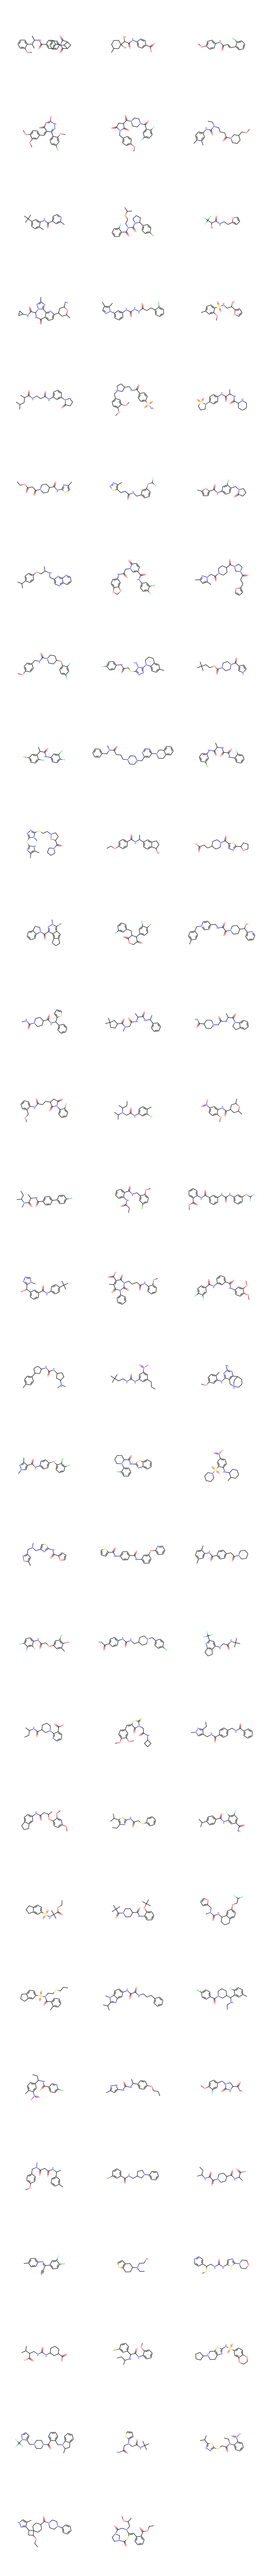

In [67]:
generated = [Chem.MolFromSmiles(x) for x in new_smiles]
Chem.Draw.MolsToGridImage(generated, molsPerRow=3, maxMols=NB_MOL, subImgSize=(400, 400))

In [68]:
print(sorted([x.GetNumAtoms() for x in generated]))

[15, 16, 18, 19, 19, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 31, 32, 32, 33, 34, 34, 34, 35, 36, 37]


In [69]:
len(generated)

86

In [70]:
good_mol_list = [x for x in generated if x.GetNumAtoms() > 10 and x.GetNumAtoms() < 50]
print(len(good_mol_list))

86


In [71]:
from rdkit.Chem import QED
qed_list = [QED.qed(x) for x in good_mol_list]
final_mol_list = [(a,b) for a,b in zip(good_mol_list,qed_list) if b > 0.1]
print(len(final_mol_list))

86


/opt/conda/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:254: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


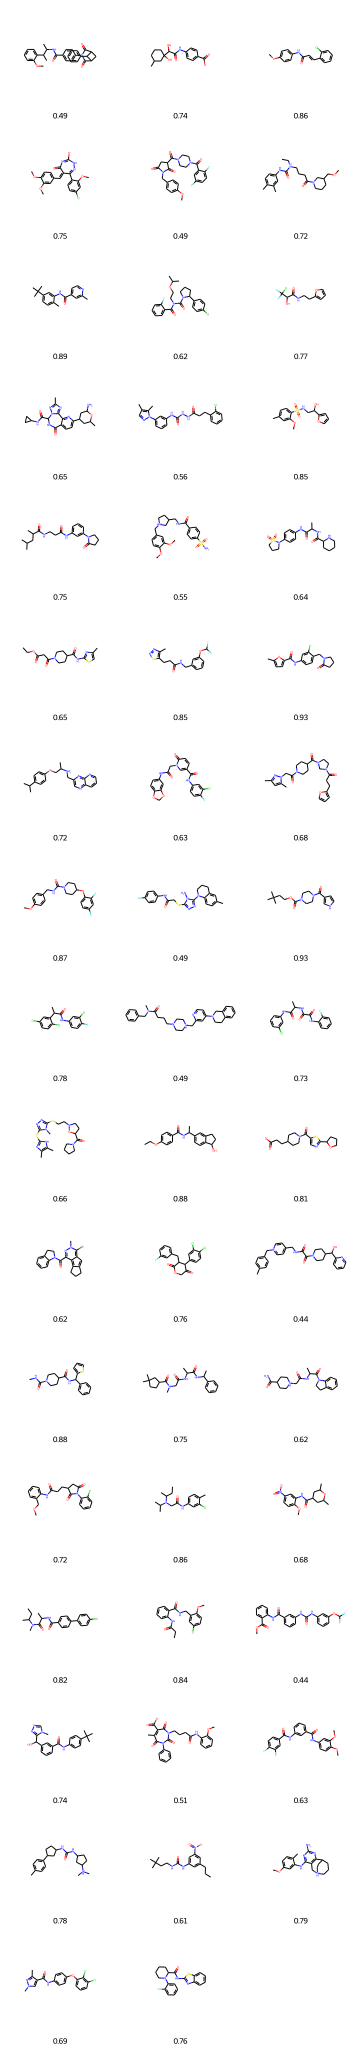

In [72]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([x[0] for x in final_mol_list],
               molsPerRow=3,useSVG=True,
               subImgSize=(250, 250),
               legends=[f"{x[1]:.2f}" for x in final_mol_list])

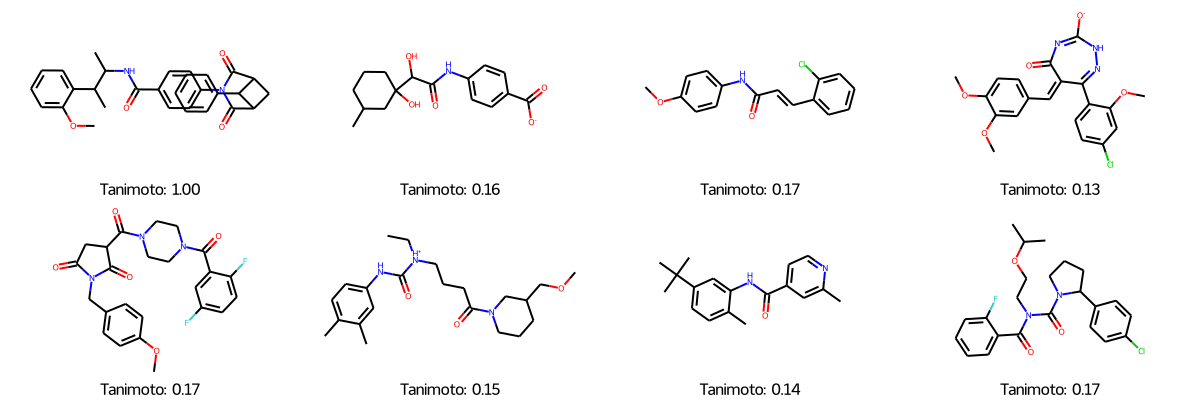

In [73]:
from rdkit.Chem import AllChem, Draw
from rdkit import rdBase, Chem, DataStructs

morgan_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048) for mol in generated]
tanimoto = DataStructs.BulkTanimotoSimilarity(morgan_fp[0], morgan_fp)
Draw.MolsToGridImage(generated[:8], molsPerRow=4, subImgSize=(300,200), legends=['Tanimoto: {:.2f}'.format(i) for i in tanimoto])


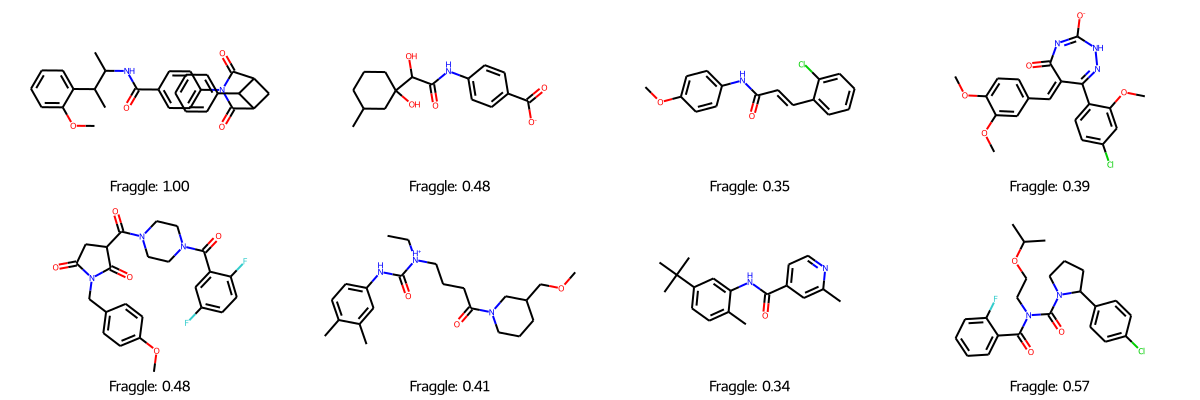

In [74]:
from rdkit.Chem.Fraggle import FraggleSim
 
fraggle_similarity = []
for (sim, match) in [FraggleSim.GetFraggleSimilarity(generated[0], generated[i]) for i in range(len(generated))]:
    fraggle_similarity.append(sim)
Draw.MolsToGridImage(generated[:8], molsPerRow=4, subImgSize=(300,200), legends=['Fraggle: {:.2f}'.format(i) for i in fraggle_similarity])

In [76]:
tspa = []
for i in range(len(generated)):
    tspa.append(Descriptors.TPSA(generated[i]))
    
ExactMolWt = []
for i in range(len(generated)):
    ExactMolWt.append(Descriptors.ExactMolWt(generated[i]))

HeavyAtomMolWt = []
for i in range(len(generated)):
    HeavyAtomMolWt.append(Descriptors.HeavyAtomMolWt(generated[i]))
    
MolWt = []
for i in range(len(generated)):
    MolWt.append(Descriptors.MolWt(generated[i]))
    
MolLogP = []
for i in range(len(generated)):
    MolLogP.append(Descriptors.MolLogP(generated[i]))
    
qed = []
for i in range(len(generated)):
    qed.append(QED.qed(generated[i]))
    
smiles_list = []
for i in range(len(generated)):
    smiles_list.append(Chem.MolToSmiles(generated[i]))
    
numatoms = []
for i in range(len(generated)):
    numatoms.append(generated[i].GetNumAtoms())
    
nhbacceptors = []
for i in range(len(generated)):
    nhbacceptors.append(rdkit.Chem.rdMolDescriptors.CalcNumHBA((generated[i])))
nbdonors = []
for i in range(len(generated)):
    nbdonors.append(rdkit.Chem.rdMolDescriptors.CalcNumHBD((generated[i])))
    
df_first_etap_sample_with_temp = pd.DataFrame(list(zip(tspa, MolLogP, qed,ExactMolWt,MolWt,HeavyAtomMolWt,smiles_list, numatoms,nhbacceptors,nbdonors)), columns = ['tspa', 'logp', 'qed','ExactMolWt','MolWt','HeavyAtomMolWt','smiles_list','num_atoms','h-acc','h-donors'])
df_first_etap_sample_with_temp.head(5)

tspa    logp       qed  ExactMolWt    MolWt  HeavyAtomMolWt  \
0   75.71  4.9103  0.485734  482.220557  482.580         452.340   
1  109.69  0.2907  0.740455  306.134696  306.338         286.178   
2   38.33  4.0005  0.863279  287.071306  287.746         273.634   
3  104.57  1.9996  0.750162  414.086222  414.825         397.689   
4   87.23  1.8331  0.490711  471.160577  471.460         448.276   

                                         smiles_list  num_atoms  h-acc  \
0  COc1ccccc1C(C)C(C)NC(=O)c1ccc(N2C(=O)C3CC(C2=O...         36      4   
1        CC1CCCC(O)(C(O)C(=O)Nc2ccc(C(=O)[O-])cc2)C1         22      5   
2                    COc1ccc(NC(=O)C=Cc2ccccc2Cl)cc1         20      2   
3  COc1ccc(C=C2C(=O)N=C([O-])NN=C2c2ccc(Cl)cc2OC)...         29      7   
4  COc1ccc(CN2C(=O)CC(C(=O)N3CCN(C(=O)c4cc(F)ccc4...         34      5   

   h-donors  
0         1  
1         3  
2         1  
3         1  
4         0

In [77]:
df_first_etap_sample_with_temp.describe()

tspa       logp        qed  ExactMolWt       MolWt  \
count   86.000000  86.000000  86.000000   86.000000   86.000000   
mean    72.291163   2.855231   0.713657  365.763807  366.200872   
std     24.279636   1.618830   0.134390   57.007188   57.043082   
min     24.670000  -1.605700   0.421428  226.126012  226.365000   
25%     54.515000   1.996840   0.622301  326.400434  326.618750   
50%     75.710000   3.242020   0.744022  361.659945  362.137000   
75%     87.282500   4.065450   0.823140  408.653122  409.399250   
max    139.530000   5.528100   0.931889  498.322737  498.695000   

       HeavyAtomMolWt  num_atoms      h-acc   h-donors  
count       86.000000  86.000000  86.000000  86.000000  
mean       343.638081  25.639535   4.058140   1.500000  
std         54.547432   4.405646   1.689794   0.929896  
min        206.205000  15.000000   1.000000   0.000000  
25%        302.202250  22.250000   3.000000   1.000000  
50%        340.186000  25.000000   4.000000   1.000000  
75%        384.623000  28.000000   5.000000   2.000000  
max        458.375000  37.000000   9.000000   4.000000

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ExactMolWt', ylabel='Density'>

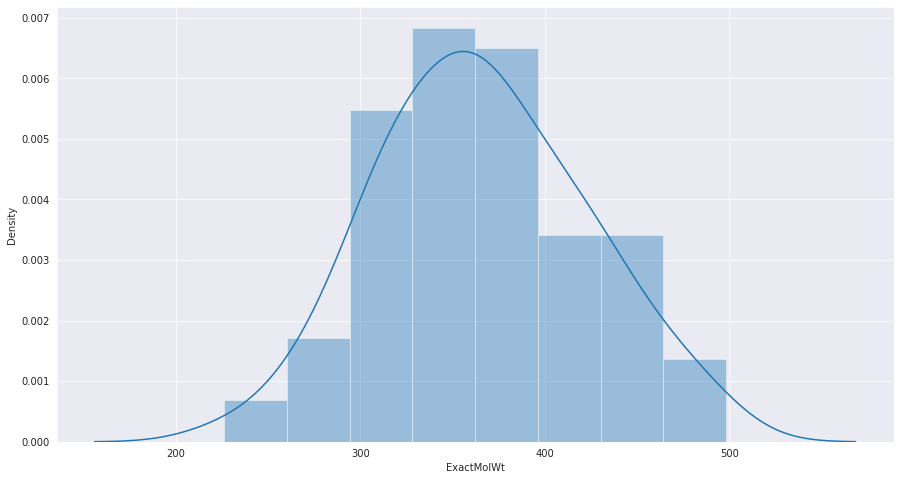

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap_sample_with_temp['ExactMolWt'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='h-donors', ylabel='Density'>

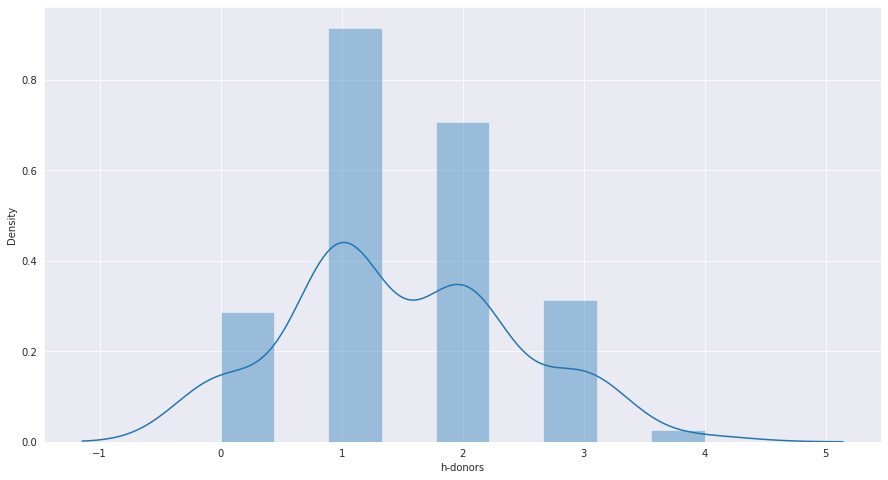

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap_sample_with_temp['h-donors'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='h-acc', ylabel='Density'>

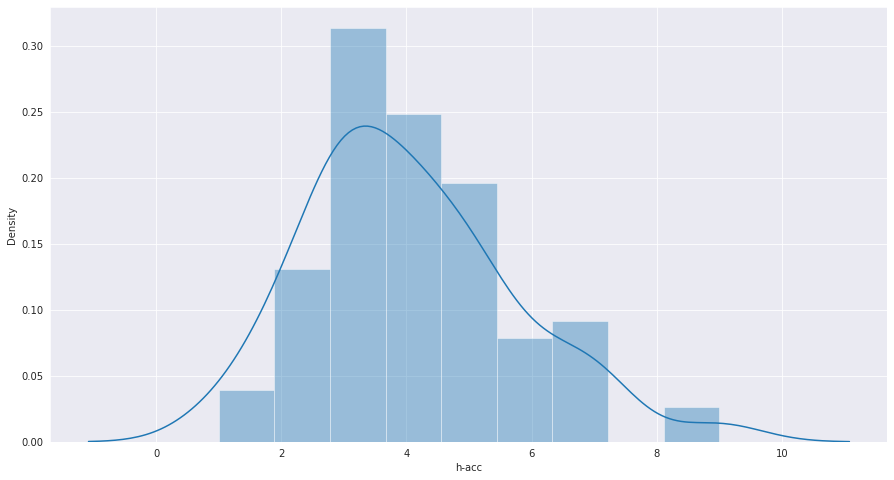

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap_sample_with_temp['h-acc'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='num_atoms', ylabel='Density'>

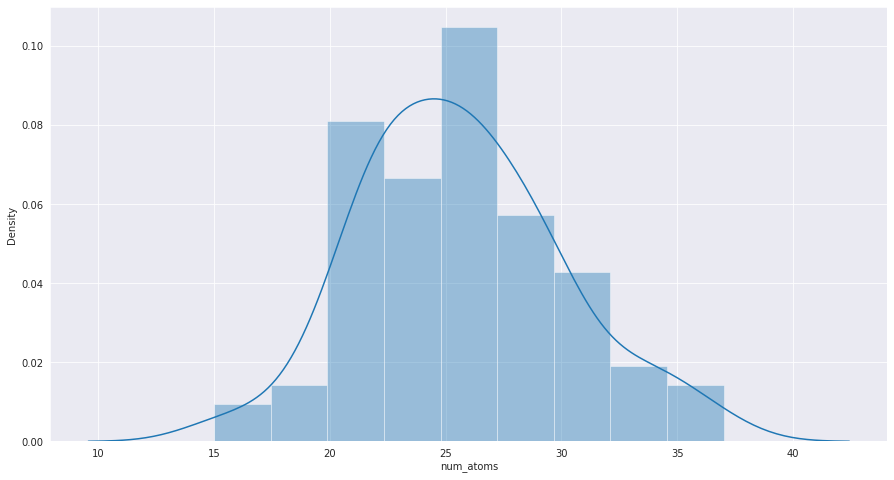

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap_sample_with_temp['num_atoms'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='logp', ylabel='Density'>

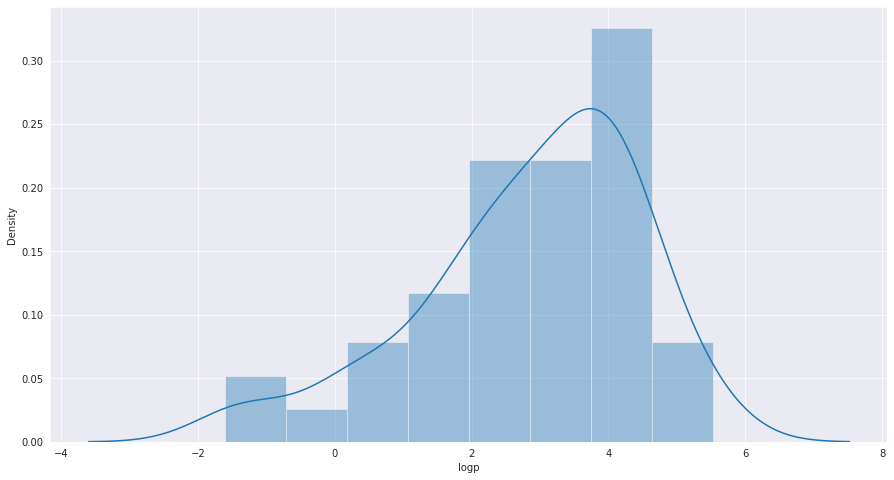

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap_sample_with_temp['logp'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='qed', ylabel='Density'>

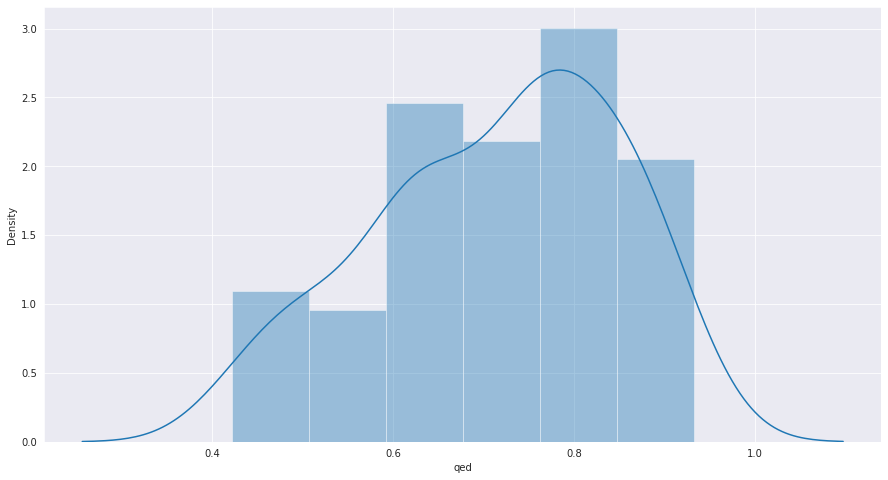

In [82]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap_sample_with_temp['qed'])

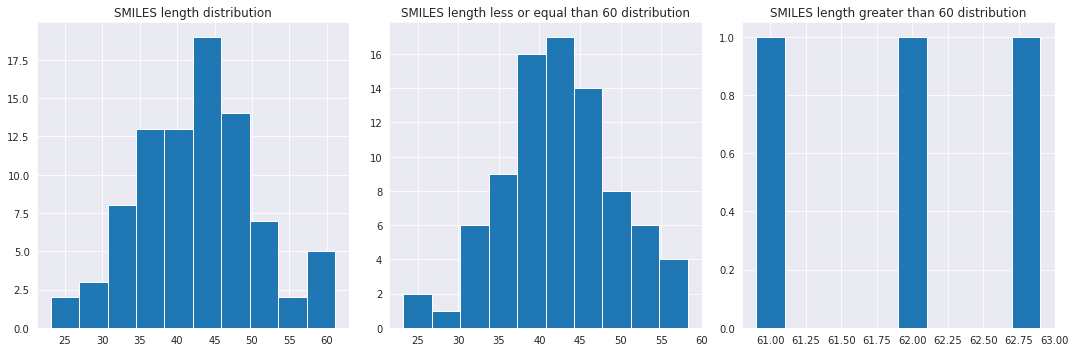

In [83]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
axes[0].set_title("SMILES length distribution")
axes[0].hist(df_first_etap_sample_with_temp['smiles_list'].str.len(), align = 'left')
axes[1].set_title("SMILES length less or equal than 60 distribution")
axes[1].hist(df_first_etap_sample_with_temp[df_first_etap_sample_with_temp['smiles_list'].str.len() <= 60]['smiles_list'].str.len(), align = 'left')
axes[2].set_title("SMILES length greater than 60 distribution")
axes[2].hist(df_first_etap_sample_with_temp[df_first_etap_sample_with_temp['smiles_list'].str.len() > 60]['smiles_list'].str.len(), align = 'left')
fig.tight_layout()

In [85]:
def generate(model,sequence,tokenizer,MAX_LEN=128):
    while (sequence[-1] != 'E') and (len(tokenizer.tokenize(sequence)) <= MAX_LEN):
        x = tokenizer.one_hot_encode(tokenizer.tokenize(sequence))
        preds = model.predict_on_batch(x)[0][-1]
        next_idx = greedy_search(preds)
        sequence += tokenizer.table[next_idx]
        
    sequence = sequence[1:].rstrip('E')
    return sequence

    
def greedy_search(preds):
    return (np.argmax(preds))   

In [86]:
import os
from rdkit import Chem
tokenizer=SmilesTokenizer()
from tqdm.notebook import tqdm

TOKENIZER_TABLE_LEN=len(tokenizer.table)
WEIGHT_PATH='./lstm_chem_final.h5'
model = V_GRU(256,TOKENIZER_TABLE_LEN)
model.load_weights(WEIGHT_PATH)
print('Loaded Model Weights') 

Loaded Model Weights


In [87]:
from scipy.special import softmax
new_smiles=[]
print('Generating New Molecules')
for _ in tqdm(range(NB_MOL)):
    smile='G'
    smi=generate(model,smile,tokenizer)
    smi=check_smi(smi)
    if smi is not None and smi not in train_smiles:
        new_smiles.append(smi)

Generating New Molecules


  0%|          | 0/100 [00:00<?, ?it/s]

2022-05-04 21:14:26.975537: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-05-04 21:16:14.575725: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-05-04 21:16:36.309053: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-05-04 21:16:36.324314: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


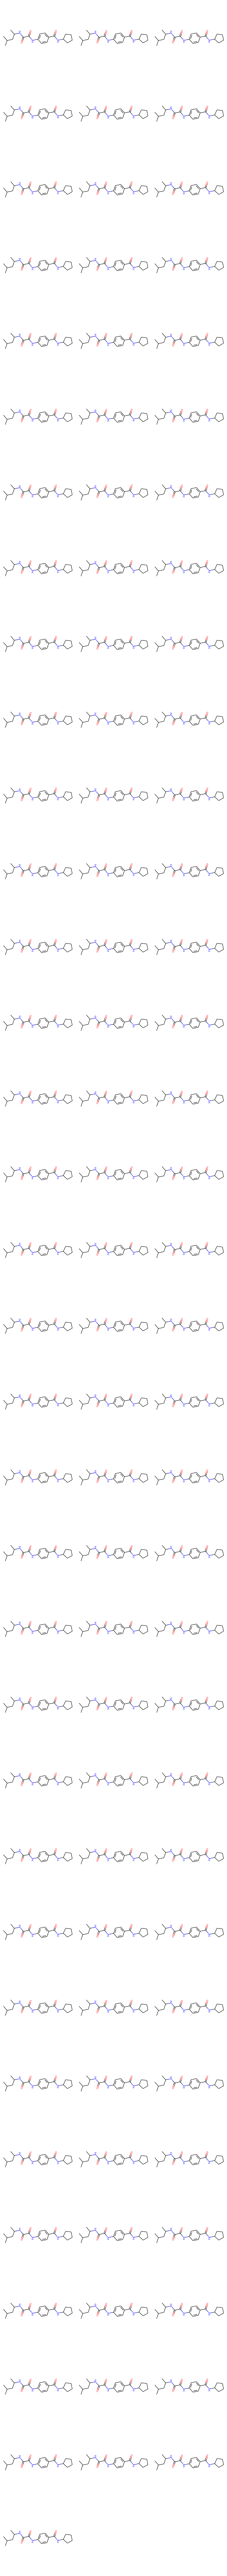

In [88]:
generated = [Chem.MolFromSmiles(x) for x in new_smiles]
Chem.Draw.MolsToGridImage(generated, molsPerRow=3, maxMols=NB_MOL, subImgSize=(400, 400))

In [89]:
print(sorted([x.GetNumAtoms() for x in generated]))

[26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26]


In [90]:
good_mol_list = [x for x in generated if x.GetNumAtoms() > 7 and x.GetNumAtoms() < 30]
print(len(good_mol_list))

100


In [91]:
from rdkit.Chem import QED
qed_list = [QED.qed(x) for x in good_mol_list]
final_mol_list = [(a,b) for a,b in zip(good_mol_list,qed_list) if b > 0.5]

/opt/conda/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:254: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


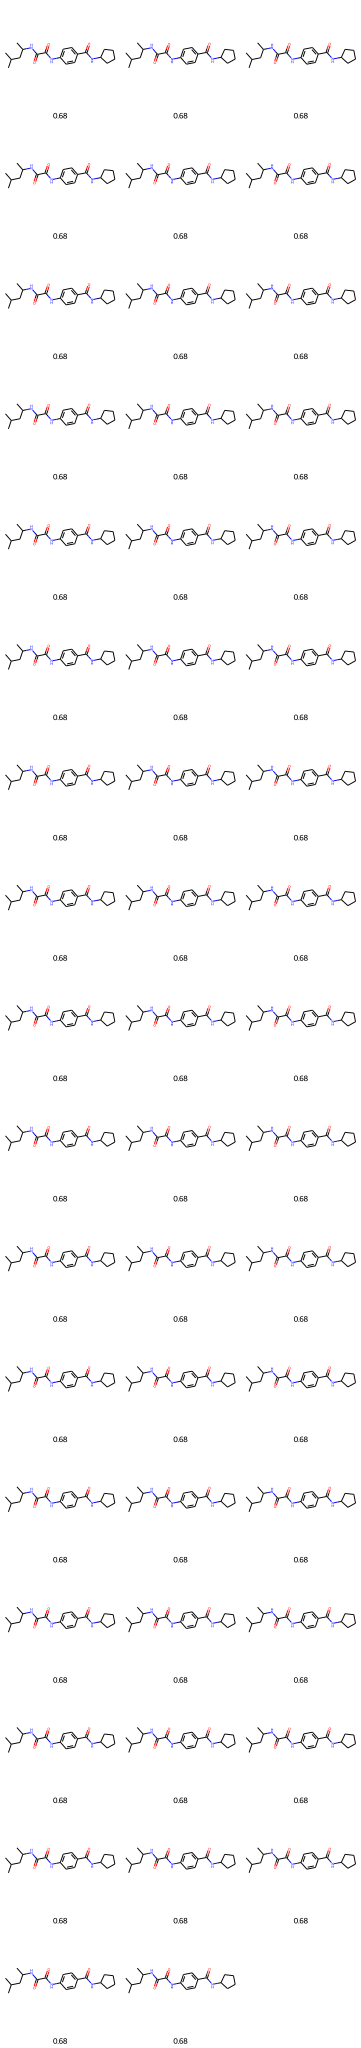

In [92]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([x[0] for x in final_mol_list],
               molsPerRow=3,useSVG=True,
               subImgSize=(250, 250),
               legends=[f"{x[1]:.2f}" for x in final_mol_list])

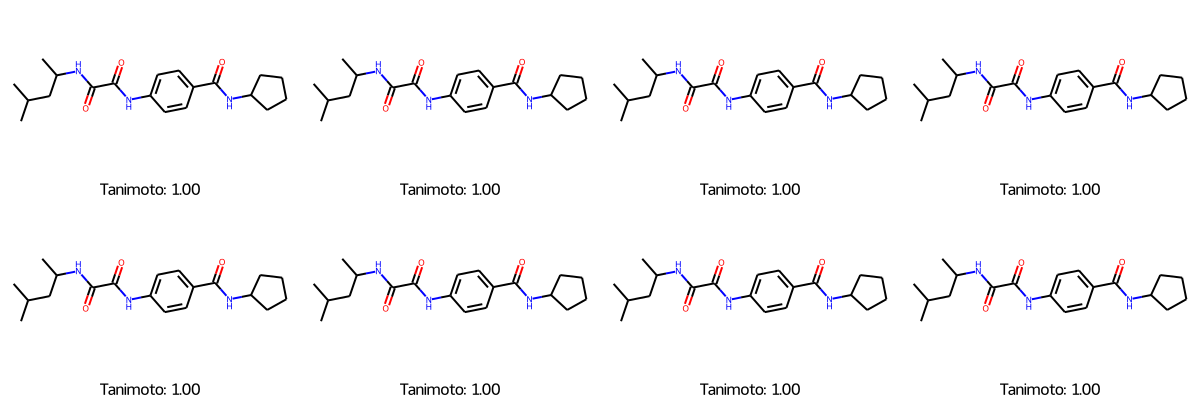

In [93]:
from rdkit.Chem import AllChem, Draw
from rdkit import rdBase, Chem, DataStructs

morgan_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048) for mol in generated]
tanimoto = DataStructs.BulkTanimotoSimilarity(morgan_fp[0], morgan_fp)
Draw.MolsToGridImage(generated[:8], molsPerRow=4, subImgSize=(300,200), legends=['Tanimoto: {:.2f}'.format(i) for i in tanimoto])

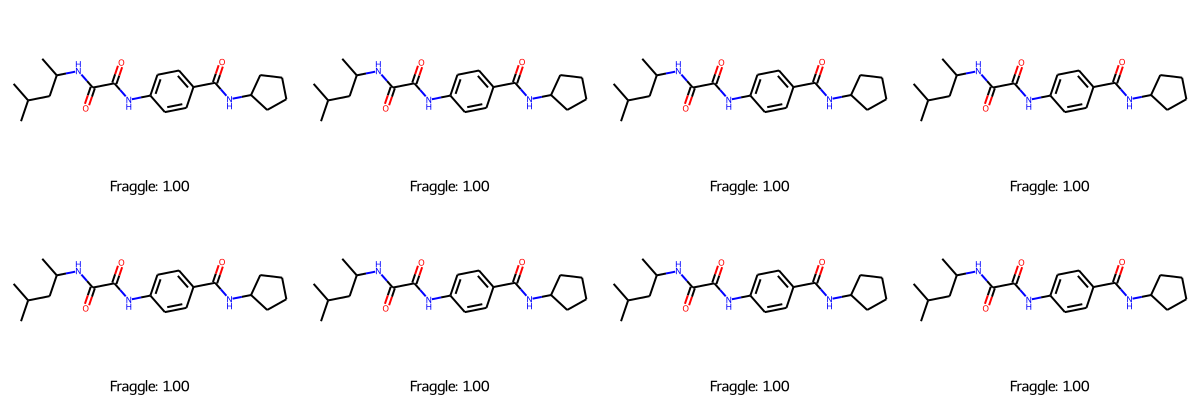

In [94]:
from rdkit.Chem.Fraggle import FraggleSim
 
fraggle_similarity = []
for (sim, match) in [FraggleSim.GetFraggleSimilarity(generated[0], generated[i]) for i in range(len(generated))]:
    fraggle_similarity.append(sim)
Draw.MolsToGridImage(generated[:8], molsPerRow=4, subImgSize=(300,200), legends=['Fraggle: {:.2f}'.format(i) for i in fraggle_similarity])

In [95]:
tspa = []
for i in range(len(generated)):
    tspa.append(Descriptors.TPSA(generated[i]))
    
ExactMolWt = []
for i in range(len(generated)):
    ExactMolWt.append(Descriptors.ExactMolWt(generated[i]))

HeavyAtomMolWt = []
for i in range(len(generated)):
    HeavyAtomMolWt.append(Descriptors.HeavyAtomMolWt(generated[i]))
    
MolWt = []
for i in range(len(generated)):
    MolWt.append(Descriptors.MolWt(generated[i]))
    
MolLogP = []
for i in range(len(generated)):
    MolLogP.append(Descriptors.MolLogP(generated[i]))
    
qed = []
for i in range(len(generated)):
    qed.append(QED.qed(generated[i]))
    
smiles_list = []
for i in range(len(generated)):
    smiles_list.append(Chem.MolToSmiles(generated[i]))
    
numatoms = []
for i in range(len(generated)):
    numatoms.append(generated[i].GetNumAtoms())
       
nhbacceptors = []
for i in range(len(generated)):
    nhbacceptors.append(rdkit.Chem.rdMolDescriptors.CalcNumHBA((generated[i])))
nbdonors = []
for i in range(len(generated)):
    nbdonors.append(rdkit.Chem.rdMolDescriptors.CalcNumHBD((generated[i])))
    
df_first_etap_greedy_search = pd.DataFrame(list(zip(tspa, MolLogP, qed,ExactMolWt,MolWt,HeavyAtomMolWt,smiles_list, numatoms,nhbacceptors,nbdonors)), columns = ['tspa', 'logp', 'qed','ExactMolWt','MolWt','HeavyAtomMolWt','smiles_list','num_atoms','h-acc','h-donors'])
df_first_etap_greedy_search.head(5)

tspa    logp       qed  ExactMolWt   MolWt  HeavyAtomMolWt  \
0  87.3  2.8483  0.682647  359.220892  359.47         330.238   
1  87.3  2.8483  0.682647  359.220892  359.47         330.238   
2  87.3  2.8483  0.682647  359.220892  359.47         330.238   
3  87.3  2.8483  0.682647  359.220892  359.47         330.238   
4  87.3  2.8483  0.682647  359.220892  359.47         330.238   

                                     smiles_list  num_atoms  h-acc  h-donors  
0  CC(C)CC(C)NC(=O)C(=O)Nc1ccc(C(=O)NC2CCCC2)cc1         26      3         3  
1  CC(C)CC(C)NC(=O)C(=O)Nc1ccc(C(=O)NC2CCCC2)cc1         26      3         3  
2  CC(C)CC(C)NC(=O)C(=O)Nc1ccc(C(=O)NC2CCCC2)cc1         26      3         3  
3  CC(C)CC(C)NC(=O)C(=O)Nc1ccc(C(=O)NC2CCCC2)cc1         26      3         3  
4  CC(C)CC(C)NC(=O)C(=O)Nc1ccc(C(=O)NC2CCCC2)cc1         26      3         3